In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray as xr

from convolve_load import load_rotation_matrices, load_elements, load_reciprocal, gather_nodes

device = "mps"

# 读入precompute的内容

* 这个任务只做一次。这些Tensors留在device，反复使用。

In [11]:
rotations = load_rotation_matrices().to(device)

solid_elements, solid_connectivity = load_elements("solid", device=device)
fluid_elements, fluid_connectivity = load_elements("fluid", device=device)

# 实际ULVZ波场

* 下面的例子是从文件读取的。
* 反演时，它们是FNO的输入和输出，不来自文件（否则无法backprop）。

In [12]:
incident_solid = np.load("../wave_extrapolation/outputs/incident_ml_ready_solid.npz")["arr_0"]
incident_fluid = np.load("../wave_extrapolation/outputs/incident_ml_ready_fluid.npz")["arr_0"]
outgoing_solid = np.load("../wave_extrapolation/outputs/outgoing_ml_ready_solid.npz")["arr_0"]
outgoing_fluid = np.load("../wave_extrapolation/outputs/outgoing_ml_ready_fluid.npz")["arr_0"]

# 它们的差值，是做wave extrapolate的源
ulvz_u_solid = outgoing_solid - incident_solid
ulvz_u_fluid = outgoing_fluid - incident_fluid
ulvz_u_solid = np.transpose(ulvz_u_solid, (0, 1, 3, 4, 2))  # Depth放到最后
ulvz_u_fluid = np.transpose(ulvz_u_fluid, (0, 1, 3, 4, 2))
ulvz_u_solid = torch.from_numpy(ulvz_u_solid).float().to(device)
ulvz_u_fluid = torch.from_numpy(ulvz_u_fluid).float().to(device)

# 旋转到XYZ
ulvz_u_solid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, ulvz_u_solid)

---

# 以上部分是所有站台公用的。以下是各个站台各自的convolve

---

# 读取站台的Green函数

In [13]:
# load reciprocal
station_name = "US.ERP"
recip_u_solid = load_reciprocal(ulvz_u_solid, station_name, "solid")
recip_u_fluid = load_reciprocal(ulvz_u_fluid, station_name, "fluid")

# 旋转到XYZ
recip_u_solid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, recip_u_solid)

In [14]:
print(ulvz_u_solid.shape)
print(ulvz_u_fluid.shape)
print(recip_u_solid.shape)
print(recip_u_fluid.shape)

torch.Size([250, 3, 26, 60, 16])
torch.Size([250, 1, 26, 60, 6])
torch.Size([2003, 3, 26, 60, 16])
torch.Size([2003, 1, 26, 60, 6])


# 最终Convolve

In [15]:
# 搜集位移
ulvz_u_solid_elem = gather_nodes(ulvz_u_solid, solid_connectivity)
ulvz_u_fluid_elem = gather_nodes(ulvz_u_fluid, fluid_connectivity)
recip_u_solid_elem = gather_nodes(recip_u_solid, solid_connectivity)
recip_u_fluid_elem = gather_nodes(recip_u_fluid, fluid_connectivity)

# Convolve 并求和
result = torch.zeros(len(ulvz_u_solid) + len(recip_u_solid) - 1).float().to(device)
for elem, u_ulvz, u_recip in zip(solid_elements, ulvz_u_solid_elem, recip_u_solid_elem):
    result += elem.compute_convolve(u_ulvz, u_recip)
for elem, u_ulvz, u_recip in zip(fluid_elements, ulvz_u_fluid_elem, recip_u_fluid_elem):
    result += elem.compute_convolve(u_ulvz, u_recip)

# 对比结果

In [16]:
index = 348  # US.ERP
ds_1d = xr.load_dataset("../simulations/outputs/test/04_solve_prem/output/stations/ARRAY/axisem3d_synthetics.nc.rank0")
wave_1d = ds_1d["data"][:, 1, index]
print(wave_1d.shape)

ds_3d = xr.load_dataset("../simulations/outputs/test/12_solve_3d/output/stations/ARRAY/axisem3d_synthetics.nc.rank0")
wave_3d = ds_3d["data"][:, 1, index]
print(wave_3d.shape)

(2052,)
(1451,)


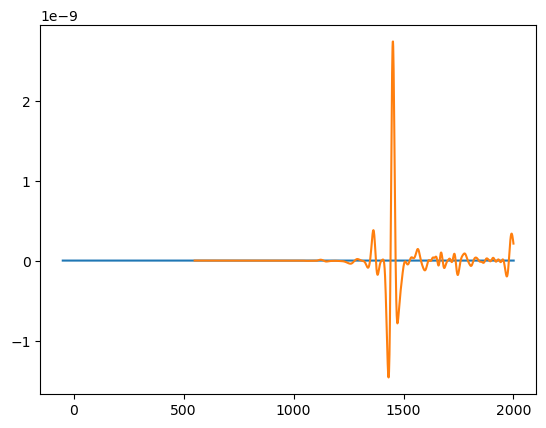

In [17]:
plt.plot(ds_1d["time_points"], wave_1d)
plt.plot(ds_3d["time_points"], wave_3d)

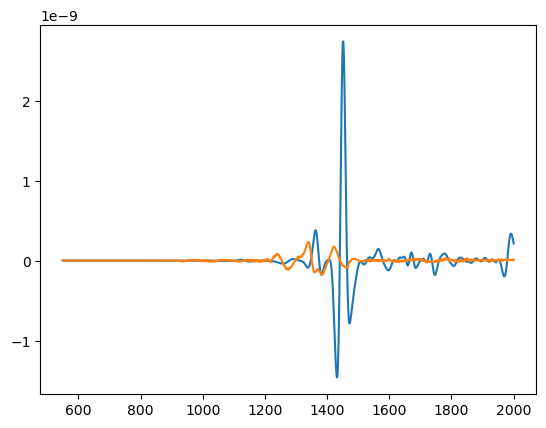

In [21]:
plt.plot(ds_3d["time_points"], wave_3d)
plt.plot(ds_3d["time_points"], result.cpu().numpy()[:len(ds_3d["time_points"])] / 1e20)